# Quickstart Guide to DSPS¶

- adapted by SDC from https://github.com/ArgonneCPAC/dsps/blob/main/docs/source/dsps_quickstart.ipynb
-  CCIN2P3 on K80 GPU
- conda environnment : conda_jax0325
- creation date : 2023/09/26
- last update  : 2023/11/10

    pip install --upgrade  "jax[cuda11_cudnn82]"=='0.3.25' "jaxlib"=='0.3.25' -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
    python -m pip install "jax[cuda11_cudnn82]"  "jaxlib[cuda11_cudnn82]"
    
    
    
| computer | processor | kernel              |    date     |
| --- | --- | --- | --- |
| CC       | CPU       | conda_jax0325_py310 | 2023-11-10  |
| macbookpro | CPU | conda_jaxcpu_py310 | 2023-11-10 |



libraries @CC
=============

- jaxlib-0.3.25+cuda11.cudnn82
- jaxopt
- optax
- corner
- arviz
- numpyro




(conda_jax0325_py310) 
`/pbs/throng/lsst/users/dagoret/desc/StellarPopulationSynthesis>pip list | grep` 

| lib | version |
|--- | --- | 
|jax  |                         0.4.20 |
|jaxlib |                       0.4.20 |
|jaxopt  |                      0.8.2 |    


Libraries


https://dsps.readthedocs.io/en/latest/dsps_quickstart.html

This demo notebook begins by downloading the DSPS default option for the SSP spectral library. These data are stored at this URL in a flat hdf5 file with column names as expected by the dsps.load_ssp_templates function, which we will demonstrate below.

When downloading and storing SSP libraries, you can optionally use the DSPS_DRN environment variable to specify the default location where DSPS will look for SSP libraries. But here we’ll just save the downloaded data to tempdata.h5, directly pass the filename to the data loader. The load_ssp_templates that we’ll use to load these SSPs is just a convenience function - all of the DSPS functions that we’ll demonstrate in this notebook accept plain arrays and floats as inputs, and so you can store your SSP data on disk in whatever format you like.

In [1]:
import jax
jax.devices()

[CpuDevice(id=0)]

## Inspect the SSP data¶

In [2]:
#! curl https://portal.nersc.gov/project/hacc/aphearin/DSPS_data/ssp_data_fsps_v3.2_lgmet_age.h5 > tempdata.h5
#! curl https://portal.nersc.gov/project/hacc/aphearin/DSPS_data/ssp_data_continuum_fsps_v3.2_lgmet_age.h5 > tempdata_v2.h5

In [3]:
from dsps import load_ssp_templates
ssp_data_b = load_ssp_templates(fn='tempdata_v2.h5')
ssp_data = load_ssp_templates(fn='tempdata.h5')

print(ssp_data._fields)

print('\nssp_lgmet.shape = {}'.format(ssp_data.ssp_lgmet.shape))
print('ssp_lg_age_gyr.shape = {}'.format(ssp_data.ssp_lg_age_gyr.shape))
print('ssp_wave.shape = {}'.format(ssp_data.ssp_wave.shape))
print('ssp_flux.shape = {}'.format(ssp_data.ssp_flux.shape))

('ssp_lgmet', 'ssp_lg_age_gyr', 'ssp_wave', 'ssp_flux')

ssp_lgmet.shape = (12,)
ssp_lg_age_gyr.shape = (107,)
ssp_wave.shape = (5994,)
ssp_flux.shape = (12, 107, 5994)


In [4]:
ssp_data.ssp_lgmet

array([-4.34771165, -3.84771165, -3.59771165, -3.34771165, -3.09771165,
       -2.84771165, -2.59771165, -2.34771165, -2.09771165, -1.84771165,
       -1.59771165, -1.34771165])

In [5]:
ssp_data.ssp_lg_age_gyr

array([-4.  , -3.95, -3.9 , -3.85, -3.8 , -3.75, -3.7 , -3.65, -3.6 ,
       -3.55, -3.5 , -3.45, -3.4 , -3.35, -3.3 , -3.25, -3.2 , -3.15,
       -3.1 , -3.05, -3.  , -2.95, -2.9 , -2.85, -2.8 , -2.75, -2.7 ,
       -2.65, -2.6 , -2.55, -2.5 , -2.45, -2.4 , -2.35, -2.3 , -2.25,
       -2.2 , -2.15, -2.1 , -2.05, -2.  , -1.95, -1.9 , -1.85, -1.8 ,
       -1.75, -1.7 , -1.65, -1.6 , -1.55, -1.5 , -1.45, -1.4 , -1.35,
       -1.3 , -1.25, -1.2 , -1.15, -1.1 , -1.05, -1.  , -0.95, -0.9 ,
       -0.85, -0.8 , -0.75, -0.7 , -0.65, -0.6 , -0.55, -0.5 , -0.45,
       -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15, -0.1 , -0.05,  0.  ,
        0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,  0.45,
        0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,
        0.95,  1.  ,  1.05,  1.1 ,  1.15,  1.2 ,  1.25,  1.3 ])

The returned ssp_data is a namedtuple storing 4 ndarrays for the age-metallicity grid of the SSP spectra. Galaxy SEDs are calculated via probability-weighted sums of these spectral templates. For a galaxy observed at some, we’ll calculate the restframe SED of two different models in the cells below:

    a galaxy with a tabulated star formation history (SFH), and metallicity Z distributed as a lognormal about some median Z, using the calc_rest_sed_sfh_table_lognormal_mdf function.

    a galaxy with SFH table and also tabulated history of metallicity (ZH), using the calc_rest_sed_sfh_table_met_table function.

In the cells below, we’ll randomly generate an SFH and ZH for a galaxy, and then plot the results.

In [6]:
import numpy as np

gal_t_table = np.linspace(0.05, 13.8, 100) # age of the universe in Gyr
gal_sfr_table = np.random.uniform(0, 10, gal_t_table.size) # SFR in Msun/yr

gal_lgmet = -2.0 # log10(Z)
gal_lgmet_scatter = 0.2 # lognormal scatter in the metallicity distribution function


The SED calculating functions require you specify the time of the observation, t_obs, rather than the redshift, z_obs. We’ll use the age_at_z function in dsps.cosmology to calculate the relationship between these two quantities, assuming the default redshift of DSPS. You could also use this same function to compute gal_t_table in case your input SFH is tabulated as a function of redshift.

In [7]:
from dsps.cosmology import age_at_z, DEFAULT_COSMOLOGY

print(DEFAULT_COSMOLOGY)

z_obs = 0.5
t_obs = age_at_z(z_obs, *DEFAULT_COSMOLOGY) # age of the universe in Gyr at z_obs
t_obs = t_obs[0] # age_at_z function returns an array, but SED functions accept a float for this argument

CosmoParams(Om0=0.3075, w0=-1.0, wa=0.0, h=0.6774)


In [8]:
from dsps import calc_rest_sed_sfh_table_lognormal_mdf
from dsps import calc_rest_sed_sfh_table_met_table

sed_info = calc_rest_sed_sfh_table_lognormal_mdf(
    gal_t_table, gal_sfr_table, gal_lgmet, gal_lgmet_scatter,
    ssp_data.ssp_lgmet, ssp_data.ssp_lg_age_gyr, ssp_data.ssp_flux, t_obs)


gal_lgmet_table = np.linspace(-3, -2, gal_t_table.size)

sed_info2 = calc_rest_sed_sfh_table_met_table(
    gal_t_table, gal_sfr_table, gal_lgmet_table, gal_lgmet_scatter,
    ssp_data.ssp_lgmet, ssp_data.ssp_lg_age_gyr, ssp_data.ssp_flux, t_obs)

In [9]:
sed_info3 = calc_rest_sed_sfh_table_lognormal_mdf(
    gal_t_table, gal_sfr_table, gal_lgmet, gal_lgmet_scatter,
    ssp_data_b.ssp_lgmet, ssp_data_b.ssp_lg_age_gyr, ssp_data_b.ssp_flux, t_obs)


gal_lgmet_table_b = np.linspace(-3, -2, gal_t_table.size)

sed_info4 = calc_rest_sed_sfh_table_met_table(
    gal_t_table, gal_sfr_table, gal_lgmet_table, gal_lgmet_scatter,
    ssp_data_b.ssp_lgmet, ssp_data_b.ssp_lg_age_gyr, ssp_data_b.ssp_flux, t_obs)

In [10]:
# calc_rest_sed_sfh_table_lognormal_mdf?

Text(0.5, 0, '$\\lambda  (\\AA)$')

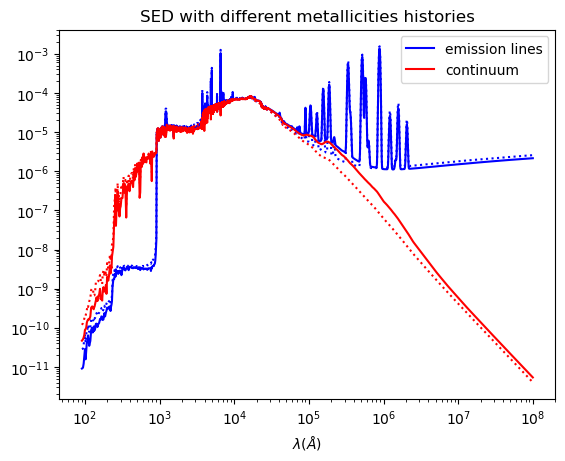

In [11]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 1)
__=ax.loglog()
__=ax.plot(ssp_data.ssp_wave, sed_info.rest_sed,'b-',label="emission lines")
__=ax.plot(ssp_data.ssp_wave, sed_info2.rest_sed,'b:')

__=ax.plot(ssp_data_b.ssp_wave, sed_info3.rest_sed,'r-',label='continuum')
__=ax.plot(ssp_data_b.ssp_wave, sed_info4.rest_sed,'r:')

ax.legend()
ax.set_title("SED with different metallicities histories")
ax.set_xlabel("$\lambda  (\\AA)$")

## Calculating photometry

Now we’ll use dsps.photometry to calculate the apparent and absolute magnitudes of an SED observed through a broadband filter. One additional ingredient we need for this calculation is the transmission curve of some filter. For this, we’ll download one from the same public URL where we previously downloaded the SSP spectra, and just write the result to a temporary file. But the load_transmission_curve function also supports the use of the DSPS_DRN environment variable in case you want DSPS to remember your default data location. The only difference is that you should store your transmission curves in the filters subdirectory of DSPS_DRN. And as above, you can also ignore this data-loading convenience function and store your transmission curves wherever you like and in whatever format you prefer.

In [12]:
#! curl https://portal.nersc.gov/project/hacc/aphearin/DSPS_data/filters/lsst_g_transmission.h5 > tempfilter.h5

In [13]:
from dsps import load_transmission_curve
lsst_g = load_transmission_curve(fn="tempfilter.h5")

print(lsst_g._fields)

print('\nlsst_g.wave.shape = {}'.format(lsst_g.wave.shape))
print('lsst_g.transmission.shape = {}'.format(lsst_g.transmission.shape))

('wave', 'transmission')

lsst_g.wave.shape = (1806,)
lsst_g.transmission.shape = (1806,)


## Calculating absolute magnitude

Since we have already calculated above the restframe SED at the time the galaxy is observed, then we can directly integrate the SED against the filter transmission curve to compute the absolute magnitude of the galaxy.

In [14]:
from dsps import calc_rest_mag
rest_mag = calc_rest_mag(ssp_data.ssp_wave, sed_info.rest_sed, lsst_g.wave, lsst_g.transmission)

## Calculating apparent magnitude

To calculate the apparent magnitude, we need to redshift the SED and also apply the appropriate cosmological dimming factor to the restframe flux. These calculations are done under-the-hood with the flat_wcdm.py module in dsps.cosmology, and so we just need to pass in the same cosmological parameters used above to calculate t_obs from z_obs.

In [15]:
from dsps import calc_obs_mag

obs_mag = calc_obs_mag(ssp_data.ssp_wave, sed_info.rest_sed, lsst_g.wave, lsst_g.transmission,
                      z_obs, *DEFAULT_COSMOLOGY)

In [16]:
obs_mag

Array(21.659609, dtype=float32)

In [17]:
calc_obs_mag?

Signature:     
calc_obs_mag(
    wave_spec_rest,
    lum_spec,
    wave_filter,
    trans_filter,
    redshift,
    Om0,
    w0,
    wa,
    h,
)
Call signature: calc_obs_mag(*args, **kwargs)
Type:           PjitFunction
String form:    <PjitFunction of <function calc_obs_mag at 0x15877fb50>>
File:           ~/anaconda3/envs/conda_jaxcpu_dsps_py310/lib/python3.10/site-packages/dsps/photometry/photometry_kernels.py
Docstring:     
Calculate the apparent magnitude of an SED observed through a filter

Parameters
----------
wave_spec_rest : ndarray of shape (n_wave, )

lum_spec : ndarray of shape (n_wave, )

wave_filter : ndarray of shape (n_filter_wave, )

trans_filter : ndarray of shape (n_filter_wave, )

redshift : float

Om0 : float

w0 : float

wa : float

h : float

Returns
-------
obs_mag : float